In this Notebook, we prepare the Proximus data into a usable mobility matrix at the level of postal codes, municipalities, arrondissements and provinces.

- Question: how should we interpret the foreigners that go abroad? The current matrix for December 21st says that there are roughly 200k people that come from abroad and go abroad. What does that mean?
- Question: how should we handle the -1 values? Is there a clever way to go about?
    - Add 0
    - Add some value between 0 and 30 (such as 10)
    - Add a random value between 0 and 30 every time
    - Extrapolate the actual value from the values at all previous days: if for some days the value goes above 30, the average value is expected to be close to 30 as well, whilst the opposite is true if the value is _always_ at -1.
- Question: how should we handle multiple visits per day (i.e. people coming from place A, visiting place B and C, and returning to place A)
- Question: the raw data is not a square matrix, so some postal codes are missing. This is not an issue after aggregation into municipalities
- Problem: Herstappe (PC 3717, NIS 73028) is not in the data (only 88 inhabitants). How to handle this?
- Question: _our_ list of postal codes is 1147 PCs long. The Internet claims there are 1169 PCs in Belgium (including special PCs for e.g. military bases). We stick with the 1147?
- Problem: There is no data for a number of small PC regions, such as Herstappe (PC 3717)
- Question: what is considered a *visit*? In corona times, people are still staying connected, but perhaps not leaving their house. How is this counted? Something is definitely visible, because the overall number of visits clearly goes down, especially in the first wave.

# Load packages

In [2]:
# import pandas as pd
import numpy as np
import glob
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
import datetime
# sys.path.insert(0, "../tools")
from covid19model.data.mobility import * # contains all necessary functions
from covid19model.visualization.utils import moving_avg

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

**Legend**

- _mllp_postalcode_ : Postalcode (PC) of the most likely living place (MLLP) of the Proximus client
- _postalcode_ : Visited postalcode (when device had consecutive transactions on the same cell in the PC for at least 15 min)
- _imsisinpostalcode_ : Number of users having that PC as MLLP 
- _habitants_ : Reference data for that PC 
- _nrofimsi_ : Number of users (proximus only) that were in the PC, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _visitors_ : extrapolated value of the users, -1 if < 30 (we can only report about groups >= 30, for GDPR reasons)
- _est_staytime_ : total time spent (in seconds) by all users in the PC
- _total_est_staytime_ : total time spend by all users on the network 
- _est_staytime_perc_ : _est_staytime_ / _total_est_staytime_ * 100% 

We are mainly interested in _nrofimsi_ , because we want to know how many people from PC _x_ travel to PC _y_. Perhaps it is interesting to, in a next stage, weigh this with respect to the length of stay.

# Load and clean data

NOTE: these private data are _not_ shared on GitHub (.gitignore). Make sure you downloaded the latest version from the S-drive and manually updated the relevant directory.

In [4]:
# Example: data for a single date. Note that the function is made to load several dates at once in a dict.

data_location = "../../data/raw/mobility/proximus/"
date='20201221'
mmprox = load_mobility_proximus(date, data_location)

# Nonessential help functions
def print_date(today):
    print('==========')
    print(today[:4], today[4:6], today[6:])
    print('==========')
    
def visualise_matrix(mmprox, cmap='Wistia', interpolation=None):
    # Note the log scale
    offset=1.01
    raw_matrix=np.log(np.array(mmprox.values, dtype=float)+offset)
    plt.imshow(raw_matrix, cmap=cmap, interpolation=interpolation)
    plt.show()
    
print_date(date)
mmprox[date]

Loaded dataframe for date 20201221.
2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,9970,9971,9980,9981,9982,9988,9990,9991,9992,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,1080
1020,1063,12727,753,362,496,259,714,728,155,284,...,-1,-1,0,0,0,0,0,-1,0,406
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,-1,-1,0,1432
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,-1,-1,0,2527
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,-1,0,0,0,0,-1,0,0,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0,0,0,0,0,0,-1,0,0,0,...,86,-1,-1,-1,106,760,45,74,-1,71
9990,-1,-1,-1,-1,-1,-1,-1,0,0,-1,...,-1,-1,34,-1,-1,-1,4764,817,56,145
9991,-1,0,0,0,-1,-1,0,0,0,0,...,30,40,47,-1,-1,-1,812,2623,-1,63


In [5]:
# Change the -1 values for visits to values between 1 and 30

mmprox_GDPR = GDPR_replace(mmprox[date])
print_date(date)
mmprox_GDPR

2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,9970,9971,9980,9981,9982,9988,9990,9991,9992,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,1080
1020,1063,12727,753,362,496,259,714,728,155,284,...,4,2,0,0,0,0,0,10,0,406
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,3,7,0,1432
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,3,4,0,2527
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,6,0,0,0,0,1,0,0,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,0,0,0,0,0,0,5,0,0,0,...,86,12,1,1,106,760,45,74,17,71
9990,6,23,7,1,3,2,3,0,0,10,...,4,11,34,6,1,1,4764,817,56,145
9991,3,0,0,0,6,2,0,0,0,0,...,30,40,47,1,21,10,812,2623,5,63


In [7]:
# Add missing postal codes in rows and columns

mmprox_complete = fill_missing_pc(mmprox_GDPR)
print_date(date)
mmprox_complete

2020 12 21


,1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,...,3831,5572,5589,6986,7504,7533,7543,7783,8952,9403
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
1000,12934,278,485,695,1069,1458,1264,1493,128,107,...,0,0,0,0,0,0,0,0,0,0
1020,1063,12727,753,362,496,259,714,728,155,284,...,0,0,0,0,0,0,0,0,0,0
1030,2398,959,25789,2417,1414,536,699,519,115,146,...,0,0,0,0,0,0,0,0,0,0
1040,1597,201,1883,18738,3565,427,395,255,68,93,...,0,0,0,0,0,0,0,0,0,0
1050,2654,238,719,2998,29072,1909,745,326,86,100,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Spatial aggregation

In [8]:
# Municipality level

agg='mun'
mmprox_mun = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_mun

2020 12 21


,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,4604,1694,23,441,14,1,4,168,2,101,...,0,2,9,0,0,0,0,0,0,66
11002,1071,184523,461,343,1543,2390,481,2589,68,615,...,18,28,15,32,0,31,15,67,13,3148
11004,32,811,4549,14,127,7,4,152,6,14,...,8,22,0,0,0,0,0,0,0,41
11005,465,1019,2,5271,3,18,3,79,5,67,...,0,8,9,0,0,0,0,0,0,74
11007,1,1547,99,10,2525,4,4,47,10,2,...,0,0,0,17,0,0,8,0,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0,19,0,0,0,0,0,0,0,0,...,9,38,14,54,37,4462,364,532,8,50
93056,0,36,0,0,0,1,2,0,0,0,...,8,12,100,636,362,358,3795,307,177,190
93088,0,27,0,0,0,0,0,0,0,0,...,7,10,223,120,16,637,562,8882,14,176


<IPython.core.display.Javascript object>


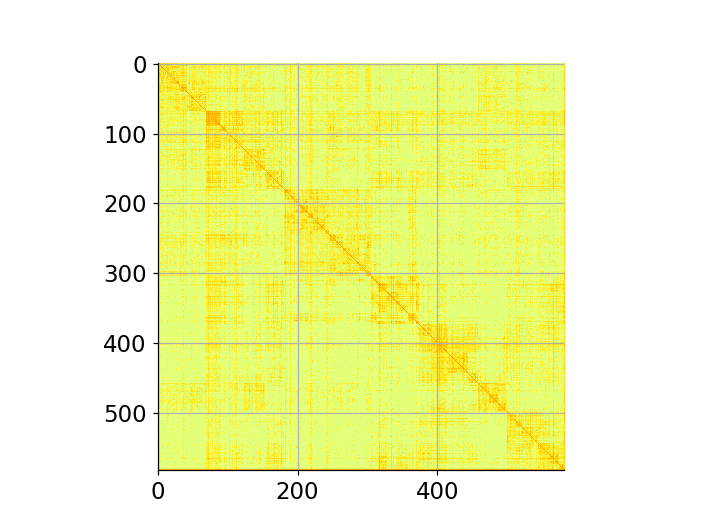

In [9]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_mun)

In [10]:
# Arrondissement level

agg='arr'
mmprox_arr = mm_aggregate(mmprox_complete, agg=agg)
mmprox_arr

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,484998,15336,11625,3940,7035,5792,2008,2848,275,742,...,1640,189,930,1381,1105,185,1353,1057,369,6923
12000,19197,155906,6851,2498,9184,9038,1164,928,117,339,...,665,136,343,687,389,155,749,569,85,1159
13000,13652,6179,208331,1435,2840,6498,778,1376,151,206,...,1339,104,409,728,421,100,405,296,123,3142
21000,4181,1945,1507,578186,56560,5933,14134,1974,151,347,...,853,587,993,1387,1315,920,2447,3345,803,20656
23000,8253,9288,2484,76267,376842,14250,16498,2740,240,557,...,1153,437,877,1465,1324,392,1970,3082,672,4583
24000,6674,9367,6973,8771,17837,275867,6662,1884,192,342,...,2463,194,749,952,772,224,1063,1867,235,1878
25000,1755,825,594,23762,18025,7057,307057,1361,50,127,...,373,668,816,1507,1837,942,2792,10438,960,4270
31000,1979,554,688,1287,1893,1074,547,134906,1001,710,...,215,44,220,567,268,152,546,430,113,1352
32000,280,75,107,156,344,74,89,1924,17393,1471,...,15,3,17,81,55,6,74,69,32,146


<IPython.core.display.Javascript object>


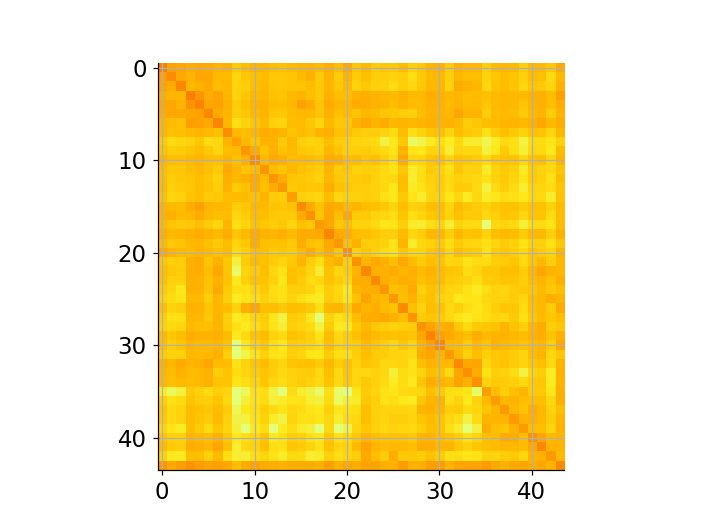

In [11]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_arr)

In [12]:
# Province level

agg='prov'
mmprox_prov = mm_aggregate(mmprox_complete, agg=agg)
print_date(date)
mmprox_prov

2020 12 21


,10000,20001,20002,21000,30000,40000,50000,60000,70000,80000,90000,ABROAD
mllp_postalcode,,,,,,,,,,,,
10000,922075,40387,3950,7873,17992,29806,6050,10359,19505,7262,5006,11224
20001,43039,684796,23160,85038,17671,36593,19554,13594,21319,7386,8889,6461
20002,3174,25082,307057,23762,4043,3048,23281,10670,1614,5770,14190,4270
21000,7633,62493,14134,578186,7124,7188,14095,8907,3212,5202,6595,20656
30000,13079,11958,2387,4958,670108,40250,20332,4798,4501,5060,4184,6206
40000,35878,39300,4004,12312,45494,837228,16723,7922,6834,7831,5778,7557
50000,4904,23061,28281,18531,25753,15610,1000413,13190,1786,7705,30135,15708
60000,4668,10910,9968,8703,6084,4001,13335,871021,12326,17495,19633,12195
70000,21145,22667,1464,3614,6291,6492,2579,15365,438618,2786,2164,7431


<IPython.core.display.Javascript object>


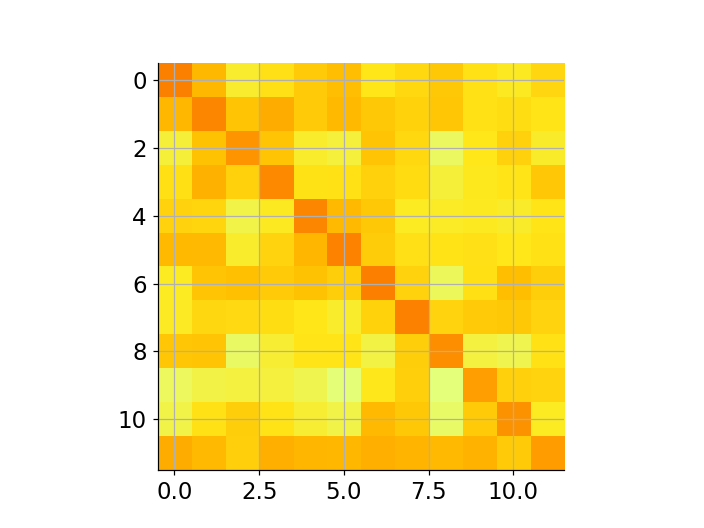

In [13]:
# logarithmic visualisation of mobility matrix
visualise_matrix(mmprox_prov)

# All-in-one solution

In [14]:
agg = 'arr'
mmprox_clean = complete_data_clean(mmprox[date], agg=agg)
mmprox_clean

,11000,12000,13000,21000,23000,24000,25000,31000,32000,33000,...,73000,81000,82000,83000,84000,85000,91000,92000,93000,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11000,485396,15338,11936,4329,7247,5596,1939,3377,268,679,...,1440,240,1053,1248,1189,188,1348,1177,423,6932
12000,19392,155972,6766,2680,9017,9124,1151,1009,116,312,...,614,171,379,617,381,144,740,556,87,1176
13000,13775,6420,208068,1643,2686,6373,829,1277,161,267,...,1203,106,433,646,426,129,406,369,126,3137
21000,3995,2096,1538,578179,56639,5981,14183,2084,199,461,...,789,513,868,1199,1491,949,2298,3314,832,20656
23000,8435,9390,2427,76182,376838,14649,16669,2948,224,467,...,1115,375,882,1338,1423,431,1879,3169,573,4608
24000,6729,9497,6917,9054,17809,275809,6504,1819,224,439,...,2353,191,638,898,868,300,1059,1779,219,1810
25000,1801,846,518,23774,18129,7048,307241,1259,73,184,...,408,576,841,1600,1777,879,2837,10564,1030,4268
31000,2036,528,609,1202,1806,1030,620,134931,968,688,...,267,40,260,534,360,109,406,391,117,1352
32000,246,63,150,152,304,106,45,1971,17399,1526,...,15,25,41,129,52,16,48,90,13,158


# Visualisation

In [16]:
# Visualisation in geopandas
import geopandas as gp

shp_dir = "../../data/raw/GIS/shapefiles/BE/"

# Load different geographical aggregations
country = gp.read_file(shp_dir + "AD_6_Country.shp")
regions = gp.read_file(shp_dir + "AD_5_Region.shp")
provinces = gp.read_file(shp_dir + "AD_4_Province.shp")
arrondissements = gp.read_file(shp_dir + "AD_3_District.shp")
municipalities = gp.read_file(shp_dir + "AD_2_Municipality.shp")

# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'

# Create circle denoting foreigners
import shapely.affinity
from shapely.geometry import Point
circle = Point(570000, 600000).buffer(1)  # type(circle)=polygon
radius = 1.3e4
ellipse = shapely.affinity.scale(circle, radius, radius)  # type(ellipse)=polygon

# Add additional column to geopandas dataframes for foreigners, depicted by circle
foreign_mun = pd.DataFrame([[np.nan, np.nan, np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=municipalities.columns)
municipalities = municipalities.append(foreign_mun, ignore_index=True)

foreign_arr = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=arrondissements.columns)
arrondissements = arrondissements.append(foreign_arr, ignore_index=True)

foreign_prov = pd.DataFrame([[np.nan, 'Foreigner', np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ellipse]], columns=provinces.columns)
provinces = provinces.append(foreign_prov, ignore_index=True)

## Municipality level

In [17]:
# Add columns with 'traffic to' values
to_NIS = ['44021', '21004', '11002'] # Ghent, Brussels, Antwerp
# to_NIS = ['93014']

# Prepare empty columns
for nis in to_NIS:
    municipalities['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in municipalities['NISCode'].values:
    for nis_to in to_NIS:
        municipalities.loc[municipalities['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


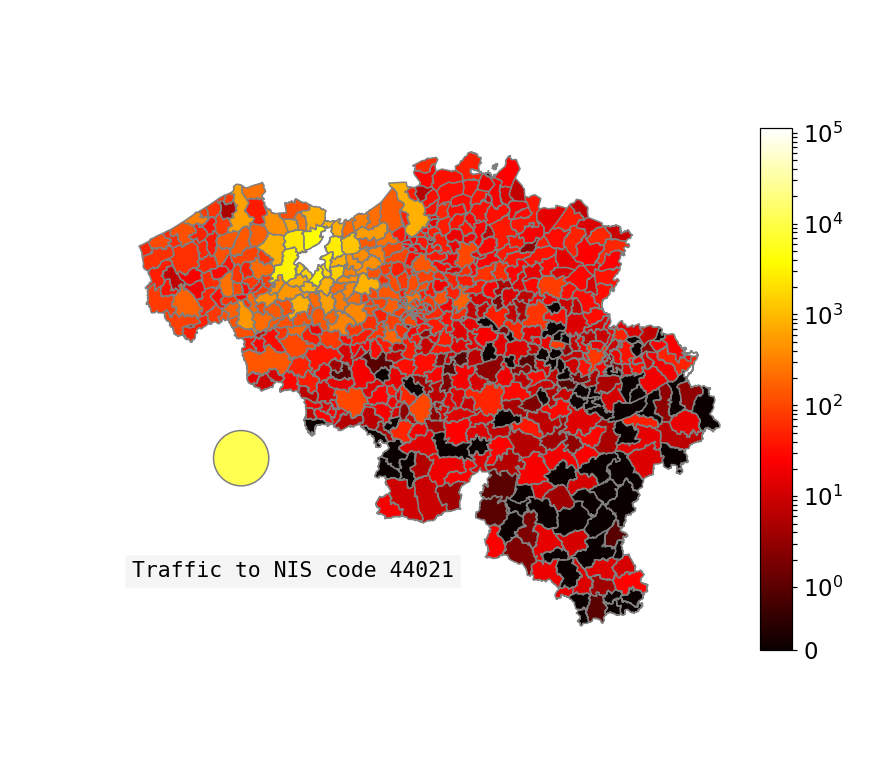

<IPython.core.display.Javascript object>


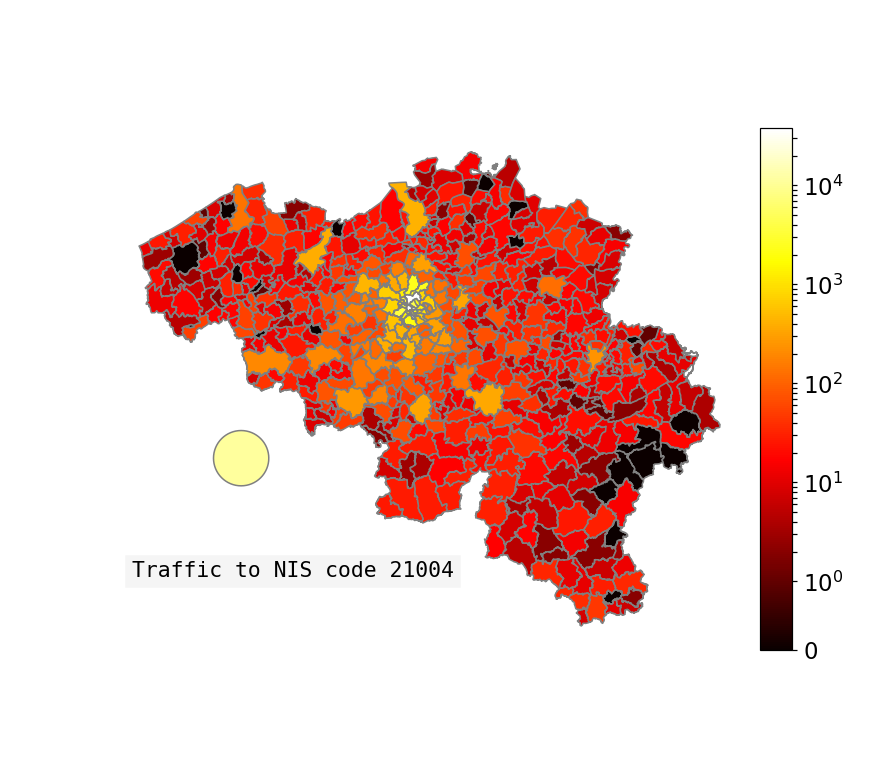

<IPython.core.display.Javascript object>


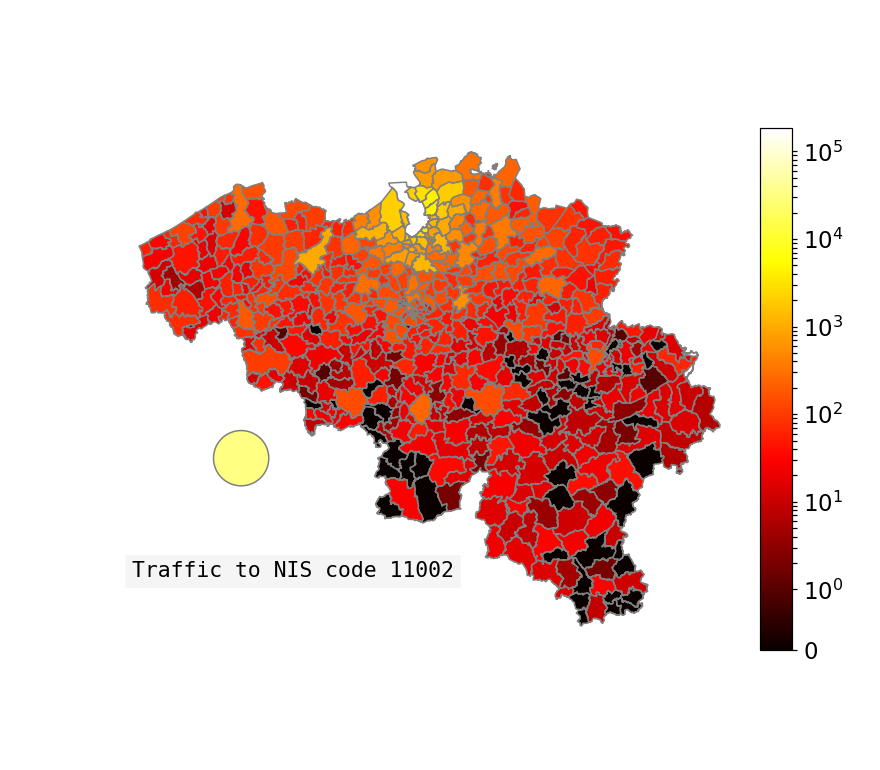

In [18]:
# Plot connections

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(municipalities['Traffic to ' + nis])
    fig = municipalities.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
#     plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/municipalities/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Arrondissement level

In [19]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['44000', '21000', '11000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    arrondissements['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in arrondissements['NISCode'].values:
    for nis_to in to_NIS:
        arrondissements.loc[arrondissements['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_arr.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


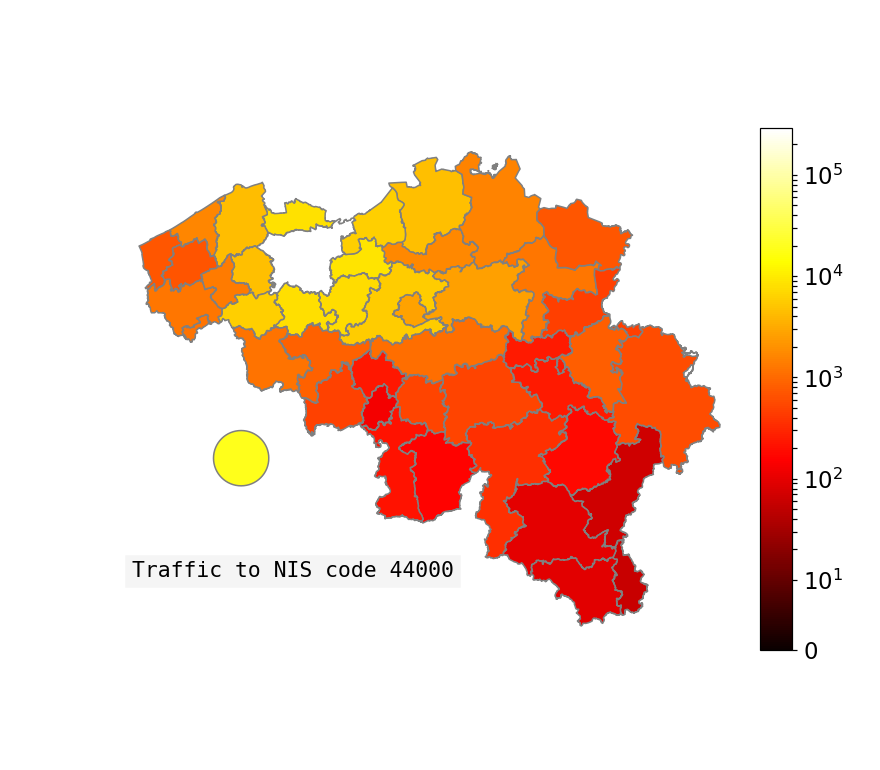

<IPython.core.display.Javascript object>


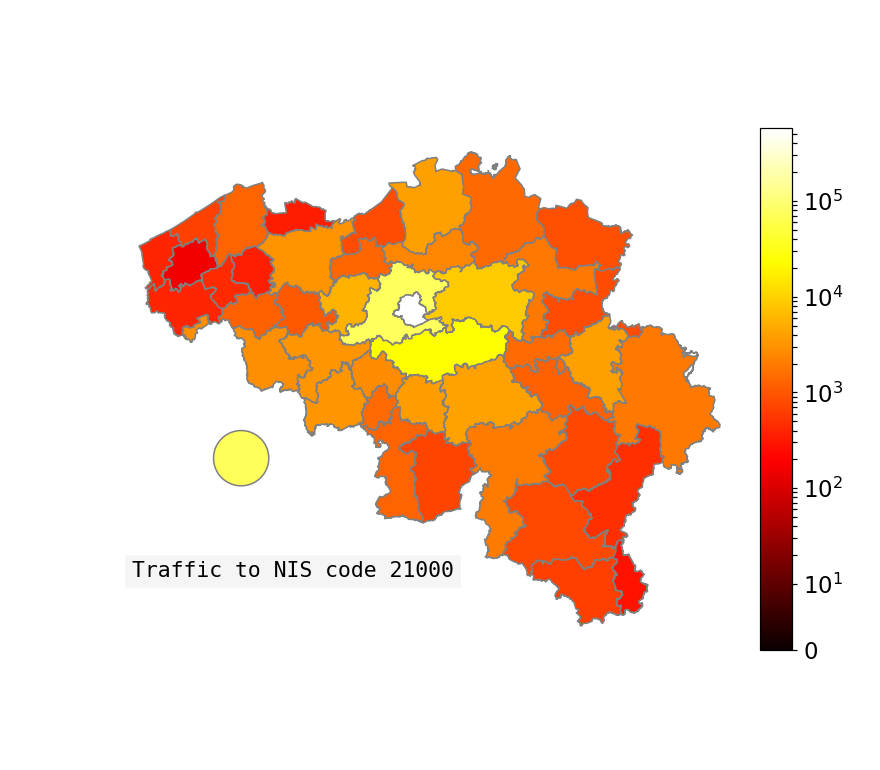

<IPython.core.display.Javascript object>


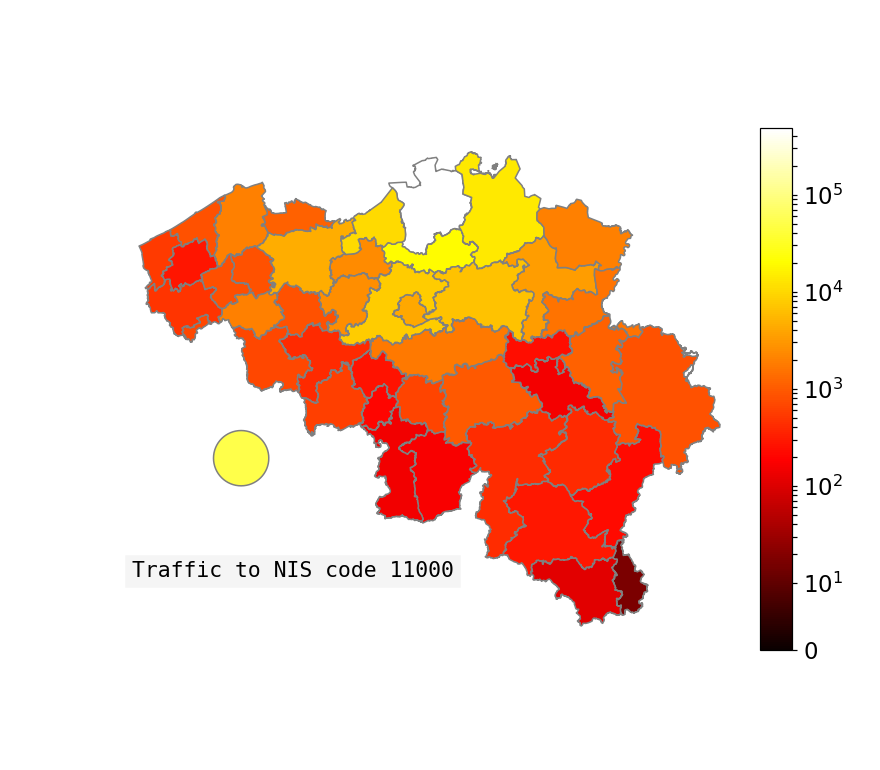

In [20]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(arrondissements['Traffic to ' + nis])
    fig = arrondissements.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/arrondissements/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

## Province level

In [21]:
# visualise in geopandas

# Add columns with 'traffic to' values
to_NIS = ['40000', '21000', '10000'] # Ghent, Brussels, Antwerp

# Prepare empty columns
for nis in to_NIS:
    provinces['Traffic to ' + nis] = 0
    
# Add value to proper column
for nis_from in provinces['NISCode'].values:
    for nis_to in to_NIS:
        provinces.loc[provinces['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_prov.loc[nis_from, nis_to]

<IPython.core.display.Javascript object>


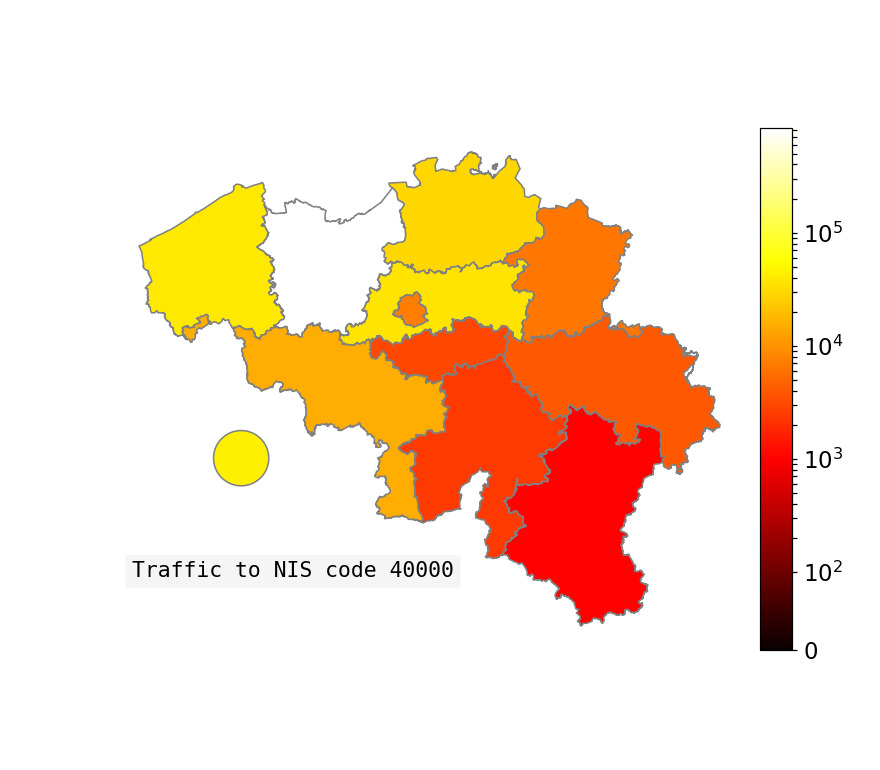

<IPython.core.display.Javascript object>


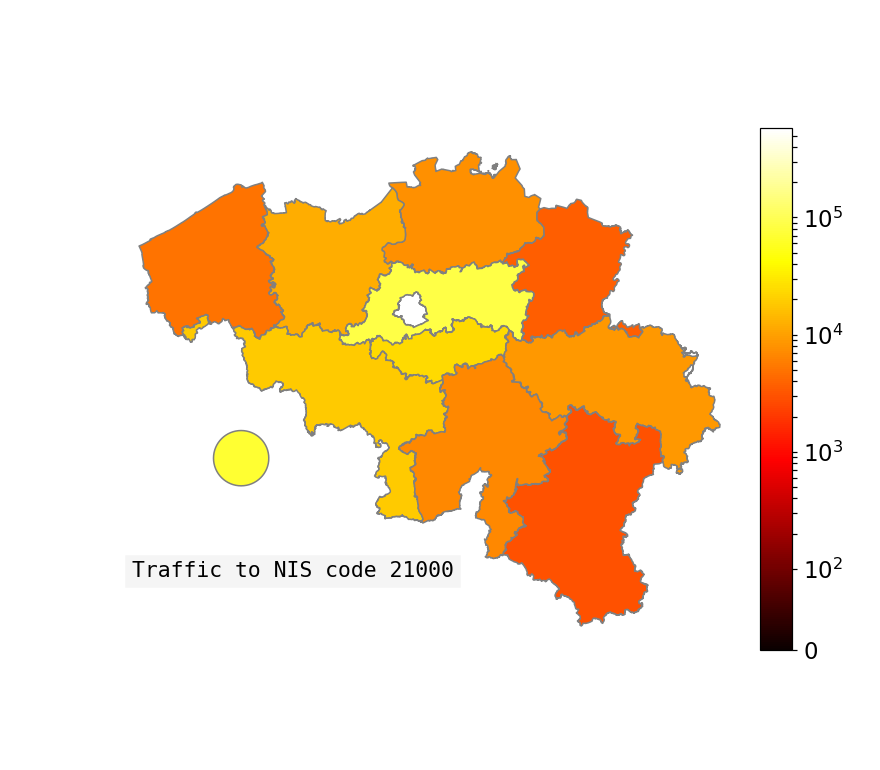

<IPython.core.display.Javascript object>


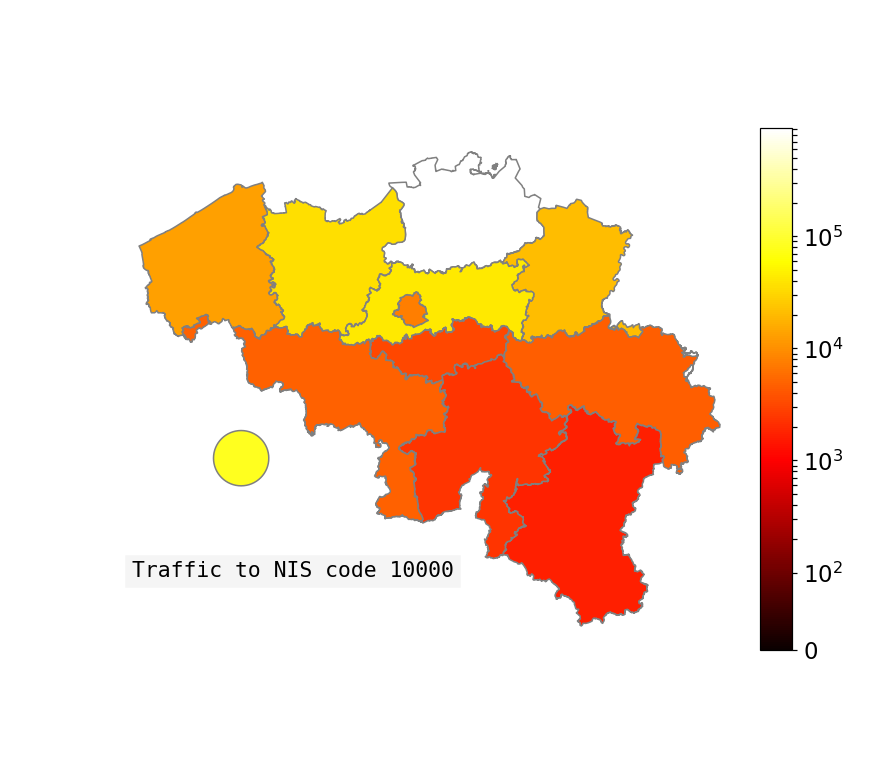

In [22]:
# Plot connections

for nis in to_NIS:
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    
    vmin=0
    vmax=max(provinces['Traffic to ' + nis])
    fig = provinces.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=100, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox = 'Traffic to NIS code ' + nis
    plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    # plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/provinces/time_series_tests/'
    chart = fig.get_figure()
    # chart.savefig('time-delays_arr_to_' + arr + '.jpg' ,dpi=50, bbox_inches='tight')

# Temporal aggregation

In [26]:
# TAKES A WHILE TO LOAD

# Select dates of the week the mobility will be averaged over
week_nr = 51
dates=make_date_list(week_nr) # [YYYYMMDD, ...]

# Load data for all these dates
location = '../../data/raw/mobility/proximus/'
mmprox = load_mobility_proximus(dates, data_location)

# Clean data for all dates
agg='mun'
for date in mmprox:
    mmprox[date] = complete_data_clean(mmprox[date], agg=agg)

... proceeding with 6 dates.
Loaded dataframe for date 20201220.    


In [27]:
# Take average of all mobility matrices in the mmprox dictionary
mmprox_avg = average_mobility(mmprox)
mmprox_avg

,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,4640.500000,1705.833333,11.833333,436.833333,5.500000,7.500000,2.666667,176.666667,6.500000,97.500000,...,0.000000,3.000000,2.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.833333
11002,1067.500000,191359.333333,540.833333,401.500000,1528.666667,2677.666667,562.500000,2722.000000,94.333333,654.500000,...,23.833333,61.166667,10.333333,35.666667,7.166667,13.166667,24.833333,28.333333,23.333333,2726.000000
11004,35.000000,954.500000,4600.833333,9.666667,155.000000,7.833333,7.666667,176.166667,7.666667,12.500000,...,0.000000,3.666667,0.000000,0.333333,0.666667,0.000000,0.000000,0.166667,0.000000,45.500000
11005,492.666667,1052.333333,7.500000,5269.000000,5.666667,3.000000,3.166667,78.500000,1.833333,79.000000,...,0.000000,3.500000,1.833333,0.000000,0.000000,0.000000,0.000000,0.333333,4.000000,61.166667
11007,7.333333,1609.666667,116.333333,8.833333,2550.666667,12.666667,5.000000,35.833333,4.166667,2.833333,...,3.000000,1.000000,0.000000,0.333333,0.000000,0.000000,1.000000,0.000000,0.000000,31.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0.000000,10.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,...,14.666667,22.666667,15.000000,48.166667,44.333333,4523.666667,375.333333,535.000000,11.500000,59.166667
93056,0.000000,7.333333,0.000000,0.333333,0.000000,0.166667,0.000000,1.666667,0.000000,0.000000,...,8.166667,20.500000,106.666667,633.166667,355.833333,367.000000,3823.666667,324.000000,175.666667,176.666667
93088,2.833333,35.333333,0.166667,0.833333,0.000000,0.166667,0.333333,0.000000,1.500000,0.000000,...,16.500000,29.333333,224.666667,106.166667,10.000000,666.166667,670.500000,8920.166667,15.666667,111.166667


In the cell below, we save processed mobility data to `data/interim/mobility/`. This directory is also put in .gitignore. You may have to create this directory locally first (because it is ignored while uploading to GitHub)

In [29]:
# Save the weekly average as a CSV.
# NOTE: TAKES LONG TIME

year = 2020
agg = 'mun'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + agg + "_" + mob_type + '_' + str(year) + "-week"
weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

location = "../../data/raw/mobility/proximus/"

for week in weeks:
    # Load all data
    dates = make_date_list(week, year)
    mmprox_dict_tmp = load_mobility_proximus(dates, data_location)
    for date in mmprox_dict_tmp:
        mmprox_dict_tmp[date] = complete_data_clean(mmprox_dict_tmp[date], agg=agg)
        print(f"Cleaned dataframe for date {date}")
    mmprox_avg = average_mobility(mmprox_dict_tmp)
    # Save all data
    save_name = save_location + save_prefix + str(week)
    mmprox_avg.to_csv(save_name)
    print(f"Saved average of week {week}.")

In [34]:
# Load the weekly average in the proper way (test)

mob_type = 'visits'
week = 7
agg = 'mun'

def load_avg_mobility(week, year=2020, agg='mun'):
    load_location = "../../data/interim/mobility/" + agg + '/' + mob_type + '/'
    load_prefix = "average-mobility_" + agg + "_" + mob_type + '_' + str(year) + "-week"
    load_name = load_location + load_prefix + str(week)
    index_col = 'mllp_postalcode'
    mmprox_avg = pd.read_csv(load_name, index_col=index_col)
    return mmprox_avg

mmprox_loaded = load_avg_mobility(week, agg=agg)

mmprox_loaded

,11001,11002,11004,11005,11007,11008,11009,11013,11016,11018,...,92141,92142,93010,93014,93018,93022,93056,93088,93090,ABROAD
mllp_postalcode,,,,,,,,,,,,,,,,,,,,,
11001,4323.857143,2319.142857,25.857143,481.142857,2.571429,14.571429,3.142857,237.142857,6.571429,110.142857,...,4.857143,1.142857,0.000000,0.857143,1.142857,0.714286,1.428571,0.285714,0.000000,23.285714
11002,1276.714286,211832.857143,714.000000,488.857143,1814.285714,3144.142857,649.428571,3259.142857,97.428571,762.714286,...,13.285714,83.714286,6.714286,25.857143,9.285714,16.571429,31.285714,13.428571,29.714286,700.857143
11004,37.571429,1651.714286,4515.571429,9.000000,187.285714,12.714286,15.714286,239.142857,8.142857,9.285714,...,1.571429,2.428571,0.000000,2.285714,0.000000,0.000000,3.285714,0.000000,0.571429,18.714286
11005,538.571429,1608.857143,9.285714,5154.285714,5.857143,5.285714,3.142857,129.428571,4.571429,96.428571,...,0.000000,2.857143,0.000000,0.000000,0.000000,5.142857,0.428571,0.000000,0.571429,19.714286
11007,8.857143,2326.428571,169.714286,5.857143,2589.142857,8.285714,3.714286,60.142857,1.571429,7.428571,...,0.000000,0.428571,3.857143,0.142857,0.000000,0.000000,3.714286,0.000000,0.000000,10.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93022,0.000000,11.428571,0.000000,0.428571,0.000000,0.857143,0.857143,0.000000,0.000000,0.000000,...,24.571429,26.142857,23.000000,61.285714,34.857143,4473.000000,451.000000,549.714286,13.285714,9.142857
93056,0.000000,21.428571,0.000000,0.571429,0.000000,0.000000,0.571429,0.000000,0.000000,1.000000,...,14.000000,16.142857,128.142857,662.857143,341.571429,414.428571,3714.142857,345.571429,205.714286,23.142857
93088,0.571429,46.000000,0.000000,1.000000,0.000000,1.142857,0.857143,4.428571,3.142857,0.000000,...,22.142857,28.714286,276.142857,138.857143,9.142857,729.857143,788.714286,8749.857143,19.428571,21.571429


In [35]:
# Aggregate on arr and prov level
# Definitions

def agg_mun_to_arr(mmprox_mun): # copied from mm_aggregate function
    # Rename columns
    mmprox_arr = mmprox_mun.copy()
    for nis in mmprox_arr.columns:
        if nis != 'ABROAD':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_arr.index:
        if nis != 'Foreigner':
            new_nis = nis[:-3] + '000'
            mmprox_arr = mmprox_arr.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_arr = mmprox_arr.groupby(level=0, axis=1).sum()
    mmprox_arr = mmprox_arr.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_arr

def agg_arr_to_prov(mmprox_arr):
    # Rename columns
    mmprox_prov = mmprox_arr.copy()
    for nis in mmprox_arr.columns:
        if nis not in ['ABROAD', '21000', '23000', '24000', '25000']: # Brussels is '11th province'
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(columns={nis : new_nis})

    # Rename rows
    for nis in mmprox_prov.index:
        if nis not in ['Foreigner', '21000', '23000', '24000', '25000']:
            new_nis = nis[:-4] + '0000'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis in ['23000', '24000']:
            new_nis = '20001'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})
        if nis == '25000':
            new_nis = '20002'
            mmprox_prov = mmprox_prov.rename(index={nis : new_nis})

    # Collect rows and columns with the same NIS code, and automatically order column/row names
    mmprox_prov = mmprox_prov.groupby(level=0, axis=1).sum()
    mmprox_prov = mmprox_prov.groupby(level=0, axis=0).sum().astype(int)
    
    return mmprox_prov

In [36]:
# Save the weekly average of arrondissements as a CSV.

year = 2020
save_agg = 'arr'
load_agg = 'mun'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + save_agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + save_agg + "_" + mob_type + '_' + str(year) + "-week"

weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

for week in weeks:
    # Load CSV
    mmprox_mun = load_avg_mobility(week, year=year, agg=load_agg)
    # Aggregate to higher level
    mmprox_arr = agg_mun_to_arr(mmprox_mun)
    # Save in proper location
    save_name = save_location + save_prefix + str(week)
    mmprox_arr.to_csv(save_name)
    print(f"Saved arrondissement average of week {week}.  ", end='\r')

In [38]:
# Save the weekly average of provinces as a CSV.

year = 2020
save_agg = 'prov'
load_agg = 'arr'
mob_type = 'visits'
save_location = "../../data/interim/mobility/" + save_agg + '/' + mob_type + '/'
save_prefix = "average-mobility_" + save_agg + "_" + mob_type + '_' + str(year) + "-week"

weeks = range(7,54) # week 7 is the first week with data. Week 53 is the last week of 2020

for week in weeks:
    # Load CSV
    mmprox_arr = load_avg_mobility(week, year=year, agg=load_agg)
    # Aggregate to higher level
    mmprox_prov = agg_arr_to_prov(mmprox_arr)
    # Save in proper location
    save_name = save_location + save_prefix + str(week)
    mmprox_prov.to_csv(save_name)
    print(f"Saved provincial average of week {week}.  ", end='\r')

# Temporal visualisation

<IPython.core.display.Javascript object>


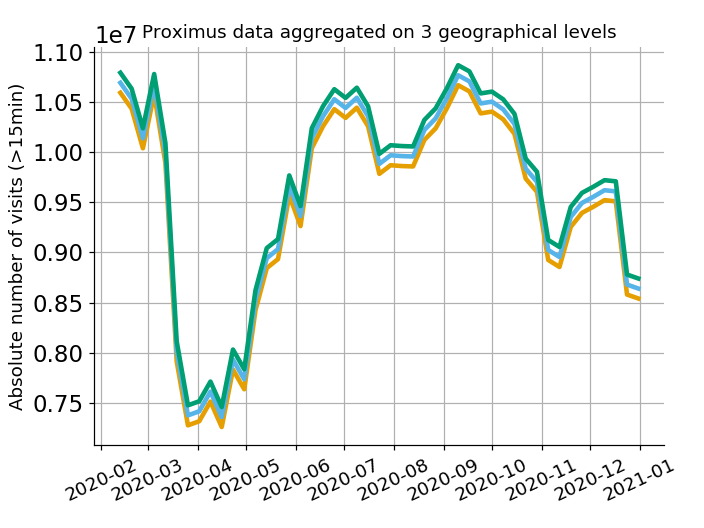

In [41]:
# All aggregations are identical: good sanity check.

year=2020
aggs=['mun', 'arr', 'prov']
weeks=np.arange(7,54)
offset=1e5 # offset for visualisation
fontsize=12


figure=plt.figure()
for idx, agg in enumerate(aggs):
    dates=[]
    total_mob=[]
    for week in weeks:
        date = week_to_date(week, day=4) # day=4 for middle of week
        dates.append(date)
        total_mob_weekly = load_avg_mobility(week, year=year, agg=agg).sum().sum()
        total_mob.append(total_mob_weekly + idx*offset)
    plt.plot(dates, total_mob)
    
plt.title('Proximus data aggregated on 3 geographical levels',fontsize=fontsize)
plt.ylabel('Absolute number of visits (>15min)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

<IPython.core.display.Javascript object>


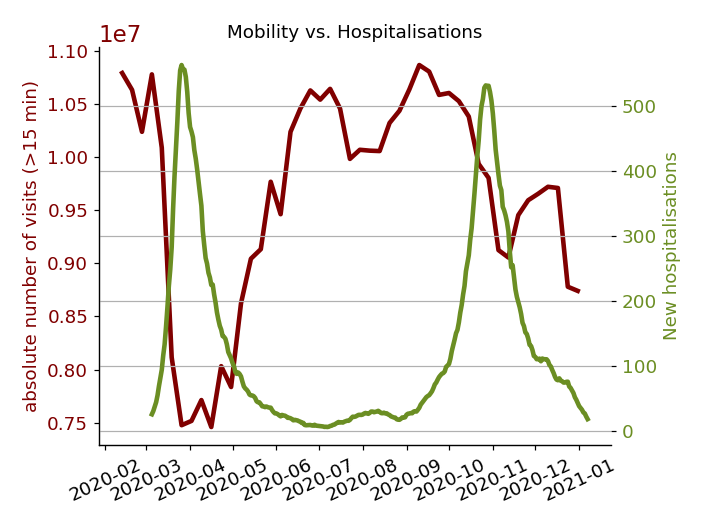

In [63]:
# Overlay total mobility over hospitalisation data

# Note: takes input from private data

fontsize=12

agg_type = 'prov'
data_file = '../../../COVID19_spatial_private/interim/all_nonpublic_timeseries_' + agg_type + '.csv'

# Load and copy the data file
raw_data = pd.read_csv(data_file, sep=',', header=0,  parse_dates = ['DATE'])
raw_data.fillna(0, inplace=True)

# select and average data
hosp_data = raw_data[['DATE','hospitalised_IN']].groupby(['DATE']).sum()
hosp_data = moving_avg(hosp_data)
hosp_indices = hosp_data.index.values
hosp_values = hosp_data['hospitalised_IN'].values


fig, ax1 = plt.subplots()
ax1.grid(False)

color = 'maroon'
# ax1.set_xlabel('date')
ax1.set_ylabel('absolute number of visits (>15 min)', color=color, fontsize=fontsize)
ax1.plot(dates, total_mob, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'olivedrab'
ax2.set_ylabel('New hospitalisations', color=color, fontsize=fontsize)  # we already handled the x-label with ax1
ax2.plot(hosp_indices, hosp_values, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize)

fig.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Mobility vs. Hospitalisations', fontsize=fontsize)
plt.show()



# figure=plt.figure()
# plt.plot(data.groupby(['DATE']).sum())
# figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
# # plt.xticks(rotation=30)
# figure.tight_layout()

# Animations

Note: this is additional and interesting for visualisation, not core science.

## Varying over destination NIS for fixed date

In [ ]:
########################
# Uncomment to execute #
########################

# # Add columns with 'traffic to' values
# to_NIS = mmprox_mun.columns

# municipalities_anim = municipalities.copy()

# # Prepare empty columns
# for nis in to_NIS:
#     municipalities_anim['Traffic to ' + nis] = 0
    
# # Add value to proper column
# for nis_from in municipalities_anim['NISCode'].values:
#     for nis_to in to_NIS:
#         municipalities_anim.loc[municipalities_anim['NISCode']==nis_from,'Traffic to ' + nis_to] = mmprox_mun.loc[nis_from, nis_to]

In [ ]:
########################
# Uncomment to execute #
########################

# Plot connections

# from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
# from matplotlib import colors

# vmin=0
# vmax=np.max(np.max(mmprox_mun))
# dpi=200

# for nis in to_NIS:
#     # Make figure
#     fig, ax = plt.subplots(figsize = (8,7)) # 1200 pixels x 1200 pixels
#     cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
#     ax.set_axis_off()
    
#     fig = municipalities_anim.plot(column='Traffic to ' + nis, ax=ax, cmap='hot',
#                                 legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

#     textbox = 'Traffic to NIS code ' + nis
#     plt.figtext(.15, .25, textbox, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
#     plt.close()

#     # (Create directory and) save figure
#     path = '../figures/maps/mun/mobility/'
#     chart = fig.get_figure()
#     chart.savefig(path+'mobility-to-NIS-' + nis + '.jpg' ,dpi=dpi, bbox_inches='tight')
#     print("saving NIS", nis)

## Varying over date for fixed destination NIS

### Straight from the data

In [64]:
# Load data for all available dates 

def get_date_from_file(filename):
    suffix_len = len(proximus_mobility_suffix())
    date_len = 8
    date = filename[-suffix_len-date_len:-suffix_len]
    return date
    
data_location = "../../data/raw/mobility/proximus/"

# ordered list of all available dates
dates_YYYYMMDD=[]
for file in os.listdir(data_location):
    if file.endswith(proximus_mobility_suffix()):
        date = get_date_from_file(file)
        dates_YYYYMMDD.append(date)

In [49]:
# Load all data in a big dictionary
### COMMENTED OUT FOR SAFETY ###

# mmprox = load_mobility_proximus(dates_YYYYMMDD, data_location)

Loaded dataframe for date 20210107.    


In [61]:
# Clean all data
# TAKES 4 seconds per date
### COMMENTED OUT FOR SAFETY ###

# agg='mun'
# mmprox_clean = dict({})
# for date in dates_YYYYMMDD:
#     mmprox_clean[date] = complete_data_clean(mmprox[date], agg=agg)
#     print(f"Total clean for date {date}.   ", end= '\r')
# print(f"Total clean for date {date}.")

Total clean for date 20210107.   


In [63]:
# Save this (locally) for future reference, because it takes a while to load/clean everything ...
# Also takes a while to save ...
### COMMENTED OUT FOR SAFETY ###

# save_location = #pick location
# save_prefix = 'çleaned-mobility-data_' + agg + '_'
# for date in dates_YYYYMMDD:
#     save_name = save_location + save_prefix + str(date)
#     mmprox[date].to_csv(save_name)
#     print(f"Saved file {save_prefix + str(date) + '.csv'}   ", end= '\r')
# print(f"Saved file {save_prefix + str(date) + '.csv'}")

Saved file çleaned-mobility-data_mun_20210107.   


In [69]:
# Sanity check: 

import datetime

dates_datetime = [datetime.datetime.strptime(date, '%Y%m%d') for date in dates_YYYYMMDD]
total_sum=[]
for date in dates_YYYYMMDD:
    total_sum.append(mmprox_clean[date].sum().sum())
    
figure=plt.figure()
plt.plot(dates_datetime, total_sum)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

Simply the 'overall' mobility is not very informative. We are more interested in actually seeing the difference in mobility play out over the days in a geographically intuitive way ...

In [213]:
# Geopandas animation

########################
# Uncomment to execute #
########################

from mpl_toolkits.axes_grid1 import make_axes_locatable # for plot aesthetics
from matplotlib import colors

chosen_nis = '11002' # Antwerpen

# Add column with 'traffic to' values
municipalities_anim = municipalities.copy()
municipalities_anim['Traffic to ' + chosen_nis] = 0

# Choose limits of legend
vmin=0
vmax=0
for date in dates:
    vmax_tmp = np.max(np.max(mmprox_clean[date]))
    if vmax_tmp > vmax : vmax = vmax_tmp

dpi=200

In [245]:
# Create sequence of geopandas maps for the chosen NIS value. Takes >1 second per image.

########################
# Uncomment to execute #
########################

# Suppress showing the images
plt.ioff()

for idx, date in enumerate(dates):
    # Prepare shapefile
    for nis_from in municipalities_anim['NISCode'].values:
        traffic_to = mmprox_clean[date].loc[nis_from, chosen_nis]
        municipalities_anim.loc[municipalities_anim['NISCode']==nis_from,'Traffic to ' + chosen_nis] = traffic_to
    
    # Make figure
    fig, ax = plt.subplots(figsize = (8,7)) # 800 pixels x 700 pixels
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1) # Legend properties
    ax.set_axis_off()
    fig = municipalities_anim.plot(column='Traffic to ' + chosen_nis, ax=ax, cmap='hot',
                                legend=True, edgecolor = 'gray', norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax), cax=cax)

    textbox1 = 'Traffic to NIS code ' + chosen_nis
    textbox2 = 'Date: ' + date
    plt.figtext(.15, .25, textbox1, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    plt.figtext(.15, .20, textbox2, backgroundcolor='whitesmoke', fontfamily='monospace', fontsize=14)
    plt.close()

    # (Create directory and) save figure
    path = '../figures/maps/mun/mobility/daily/'
    chart = fig.get_figure()
    savename = 'mobility-to-NIS-' + chosen_nis + '_' + date + '_' + str(idx) + '.jpg'
    chart.savefig(path+savename, dpi=dpi, bbox_inches='tight')
    print("saving " + savename, end='\r')
print("saving " + savename)
    
plt.ion()

saving mobility-to-NIS-11002_20210107_330.jpg


### With moving average

In [70]:
# This is not really essential but might be interesting to do: moving average
# Take moving average values for every date

import datetime
def date_shift(date, shift=0):
    date_original = datetime.datetime.strptime(date, '%Y%m%d')
    date_shifted = date_original + datetime.timedelta(days=shift)
    date_shifted_str = date_shifted.strftime('%Y%m%d')
    return date_shifted_str

def moving_avg_mobility(mmprox_dict, date, window_size=7, verbose=True):
    # Lean towards the past
    shift_left = int((window_size - window_size%2)/2) # gives 3 for 7, and 4 for 8
    shift_right = int((window_size - (window_size+1)%2)/2) # gives 3 for 7, and 3 for 8
    date_range = range(-shift_left, shift_right+1)
    dates=[date_shift(date, shift=i) for i in date_range]
    
    # Take subset of dates: only dates that are available in mmprox_dict
    dates_available = set(dates).intersection(set(mmprox_dict.keys()))
    if dates_available == set():
        raise Exception(f"Cannot average over empty set around date {date}.")
    if len(dates_available) < 3:
        print(f"Warning: dataframe set around date {date} only contains one or two elements.")
    dates_available = sorted(list(dates_available))
    
    # Calculate moving average
    first=True
    for date in dates_available:
        if first:
            mmprox_avg = mmprox_dict[date]
            first=False
        if not first:
            mmprox_avg = mmprox_avg.add(mmprox_dict[date])
    effective_window_size = len(dates_available)
    mmprox_avg = mmprox_avg / effective_window_size
    if verbose:
        print(f"Calculated moving average over {effective_window_size} dates: {dates_available}.")
    return mmprox_avg

In [71]:
# Create dictionary with moving-average values
mmprox_moving_avg=dict({})
for date in dates_YYYYMMDD:
    mmprox_moving_avg[date] = moving_avg_mobility(mmprox_clean, date, verbose=False)
    print(f"Calculated moving average for date {date}.   ", end= '\r')
print(f"Calculated moving average for date {date}.")

Exception: Cannot average over empty set around date 20200210.

In [201]:
mmprox_clean['20200218'].sum().sum()

11107202

<IPython.core.display.Javascript object>


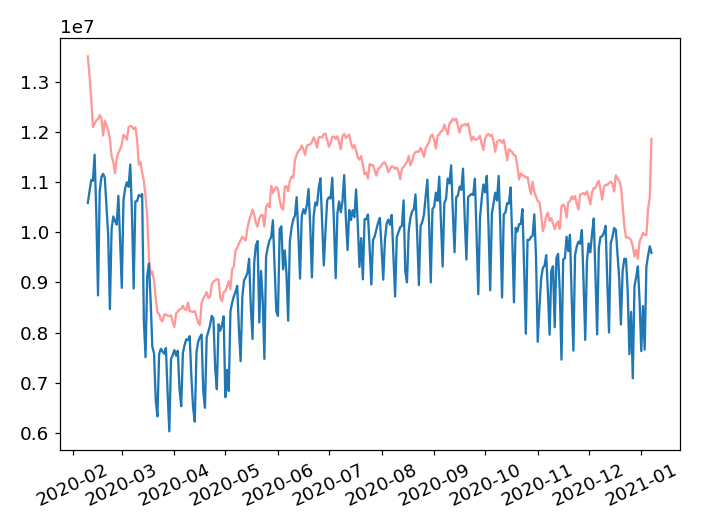

In [206]:
# Sanity check: 

dates_datetime = [datetime.datetime.strptime(date, '%Y%m%d') for date in dates]
total_sum_avg=[]
for date in dates:
    total_sum_avg.append(mmprox_moving_avg[date].sum().sum())
    
figure=plt.figure()
plt.plot(dates_datetime, total_sum_avg, color='r', alpha=0.4)
plt.plot(dates_datetime, total_sum)
figure.autofmt_xdate(bottom=.2, rotation=25, ha='center', which=None) # Automatic x-tick fix!
figure.tight_layout()

In [125]:
date='20201221'
shift_left=3
shift_right=3
date_range = range(-shift_left, shift_right+1)
for i in date_range:
    date_shift(date)
# dates=[date_shift(date, shift=i) for i in date_range]